# 0 Imports

In [4]:
from transformers import AutoProcessor, AutoModelForCausalLM
import torch
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import numpy as np


nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mattiacarlino/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# 1 Dataset and Dataloader

In [6]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
from pathlib import Path

class ImageCaptionDataset(Dataset):
    def __init__(self, image_folder, captions_file, processor):

        self.image_folder = image_folder
        self.processor = processor

        root_img, root_cpt = Path(image_folder), Path(captions_file)
        if not (root_img.exists() and root_img.is_dir()):
            raise ValueError(f"Data root '{root_img}' is invalid")
        
        if not (root_cpt.exists() and root_cpt.is_file()):
            raise ValueError(f"Data root '{root_cpt}' is invalid")

        self.df = pd.read_table(captions_file, sep=",", header=None, names=["image", "caption"], dtype='str')
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        img_name = os.path.join(self.image_folder, self.df.iloc[idx, 0])
        image = Image.open(img_name)
        caption = self.df.iloc[idx, 1]
        
        encoding = self.processor(images=image, text=caption, padding="max_length", return_tensors="pt").to(device)
        encoding = {k: v.squeeze() for k,v in encoding.items()}

        return encoding, image

In [7]:
IMG_SIZE = 224

processor = AutoProcessor.from_pretrained("microsoft/git-base")
# train_dataset = ImageCaptionDataset("../data/val_small", "../data/val_small/small_captions_val.txt", processor)
train_dataset = ImageCaptionDataset("../data/train", "../data/train/captions_train.txt", processor)
test_dataset = ImageCaptionDataset("../data/test", "../data/test/captions_test.txt", processor)

# item = train_dataset[0]
# for k,v in item.items():
	# print(k,v.shape)

/Users/mattiacarlino/anaconda3/envs/dml/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
BATCH_SIZE = 2

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)
processor.decode(batch["input_ids"][0])

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


'[CLS] a brown dog catching a ball in silhouette. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

# 2 Model definition

In [9]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base").to(device)

cpu


# 2.1 initial loss

In [6]:
outputs = model(
    input_ids=batch["input_ids"],
	attention_mask=batch["attention_mask"],
	pixel_values=batch["pixel_values"],
	labels=batch["input_ids"]
)
outputs.loss

/home/white/miniconda3/envs/dml/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


tensor(12.1147, device='cuda:0', grad_fn=<NllLossBackward0>)

# 3 Training 

In [7]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# num_epoch = 3

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# model.train()

# train_loss = []
# for epoch in range(num_epoch):
# 	for idx, batch in enumerate(train_dataloader):
# 		torch.cuda.empty_cache()
# 		input_ids = batch.pop("input_ids").to(device)
# 		pixel_values = batch.pop("pixel_values").to(device)
# 		attention_mask = batch.pop("attention_mask").to(device)

# 		outputs = model(input_ids=input_ids, pixel_values=pixel_values,labels=input_ids, attention_mask=attention_mask)
		
# 		loss = outputs.loss
# 		if (idx+1) % 10 == 0: 
# 			print(f"Epoch [{epoch+1}/{num_epoch}] - step [{idx+1}/{len(train_dataloader)}] - Loss: {loss.item():.4f}")
# 			train_loss.append(loss.item())

# 		loss.backward()

# 		optimizer.step()
# 		optimizer.zero_grad()

Epoch [1/3] - step [10/1113] - Loss: 8.5455
Epoch [1/3] - step [20/1113] - Loss: 7.4808
Epoch [1/3] - step [30/1113] - Loss: 6.4121
Epoch [1/3] - step [40/1113] - Loss: 5.3208
Epoch [1/3] - step [50/1113] - Loss: 4.1953
Epoch [1/3] - step [60/1113] - Loss: 3.0810
Epoch [1/3] - step [70/1113] - Loss: 2.0347
Epoch [1/3] - step [80/1113] - Loss: 1.2197
Epoch [1/3] - step [90/1113] - Loss: 0.6279
Epoch [1/3] - step [100/1113] - Loss: 0.3697
Epoch [1/3] - step [110/1113] - Loss: 0.3429
Epoch [1/3] - step [120/1113] - Loss: 0.2926
Epoch [1/3] - step [130/1113] - Loss: 0.2470
Epoch [1/3] - step [140/1113] - Loss: 0.1536
Epoch [1/3] - step [150/1113] - Loss: 0.1965
Epoch [1/3] - step [160/1113] - Loss: 0.1428
Epoch [1/3] - step [170/1113] - Loss: 0.0991
Epoch [1/3] - step [180/1113] - Loss: 0.1678
Epoch [1/3] - step [190/1113] - Loss: 0.1219
Epoch [1/3] - step [200/1113] - Loss: 0.1187
Epoch [1/3] - step [210/1113] - Loss: 0.0900
Epoch [1/3] - step [220/1113] - Loss: 0.1206
Epoch [1/3] - step 

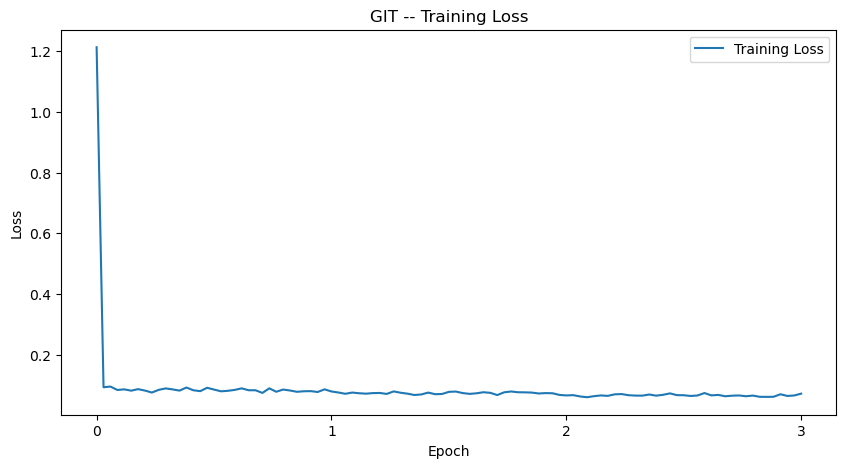

In [25]:
import matplotlib.pyplot as plt

def mean(l): return sum(l)/len(l)

lt = len(train_loss)
step = 100
t_l = [mean(train_loss[i:min(i+lt//step, lt)]) for i in range(0, lt, lt//step)]
plt.figure(figsize=(10,5))
plt.plot(t_l, label='Training Loss')
plt.title('GIT -- Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(0, len(t_l), len(t_l)//3), labels=range(0, 4))
plt.legend()
plt.show()
# plt.savefig('../img/GIT.pdf', format='pdf')

# 4 Caption generation

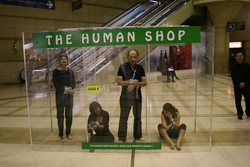

a group of people protesting by selling humans.y


In [10]:
import random

idx = random.randint(0, len(test_dataset)) 
df = pd.read_table("../data/test/captions_test.txt", sep=",", header=None, names=["image", "caption"], dtype='str')
img_name = os.path.join("../data/test", df.iloc[idx, 0])
image = Image.open(img_name)
width, height = image.size
display(image.resize((int(0.5*width), int(0.5*height))))

def generate_caption(idx, model, processor):
    encoding, image = test_dataset[idx]

    # Make sure encoding is moved to the right device
    encoding = {k: v.unsqueeze(0).to(device) for k, v in encoding.items() if k in ['input_ids', 'pixel_values']}
    
    # Generate caption
    with torch.no_grad():
        generated_ids = model.generate(**encoding, max_length=513)
    
    # Decode generated caption
    generated_caption = processor.decode(generated_ids[0], skip_special_tokens=True)

    return generated_caption

caption = generate_caption(idx, model, processor)
print(caption)

# 5 Checkpoint

In [13]:
# save model
# torch.save(
    # {
        # "model_state_dict": model.state_dict(),
        # "train_losses": train_loss,
    # },
    # "ckpt/git.ckpt",
# )

ckpt = torch.load("../ckpt/git.ckpt", map_location="cpu")

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
model.load_state_dict(ckpt["model_state_dict"])

train_loss = ckpt["train_losses"]

# 6 Blue evaluation

In [ ]:
# Assuming 'test_dataset' is your dataset containing images and captions,
# and 'generated_captions' is a list of generated captions for the images

# Initialize smoothing function for BLEU
smoothing_function = SmoothingFunction().method4

# Lists to store evaluation scores
bleu_scores = []
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

# Initialize ROUGE scorer
rouge = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# Loop through the test dataset and calculate BLEU and ROUGE scores
for idx in range(len(test_dataset)):
    # Get the ground truth captions (list of 5 captions) and the generated caption
    reference_captions = [test_dataset.df.iloc[idx]["caption"] for _ in range(5)]
    generated_caption = generate_caption(idx, model, processor)

    # Tokenize reference captions and generated caption
    reference_tokens = [nltk.word_tokenize(ref.lower()) for ref in reference_captions]
    generated_tokens = nltk.word_tokenize(generated_caption.lower())

    # Calculate BLEU score with multiple references
    bleu_score = sentence_bleu(
        reference_tokens, generated_tokens, smoothing_function=smoothing_function
    )
    bleu_scores.append(bleu_score)

    # Calculate ROUGE scores for each reference and keep the best match
    rouge_scores = [rouge.score(ref, generated_caption) for ref in reference_captions]
    best_rouge1 = max([score["rouge1"].fmeasure for score in rouge_scores])
    best_rouge2 = max([score["rouge2"].fmeasure for score in rouge_scores])
    best_rougeL = max([score["rougeL"].fmeasure for score in rouge_scores])

    rouge1_scores.append(best_rouge1)
    rouge2_scores.append(best_rouge2)
    rougeL_scores.append(best_rougeL)

# Calculate average scores
avg_bleu_score = np.mean(bleu_scores)
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

# Print average scores
print(f"Average BLEU Score: {avg_bleu_score:.4f}")
print(f"Average ROUGE-1 Score: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 Score: {avg_rouge2:.4f}")
print(f"Average ROUGE-L Score: {avg_rougeL:.4f}")

In [ ]:
# Plot BLEU Score Distribution
plt.figure(figsize=(10, 5))
plt.hist(bleu_scores, bins=20, color='blue', alpha=0.7)
plt.title('BLEU Score Distribution')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.show()

# Plot ROUGE-1 Score Distribution
plt.figure(figsize=(10, 5))
plt.hist(rouge1_scores, bins=20, color='green', alpha=0.7)
plt.title('ROUGE-1 Score Distribution')
plt.xlabel('ROUGE-1 Score')
plt.ylabel('Frequency')
plt.show()

# Plot BLEU vs ROUGE-1 Score
plt.figure(figsize=(10, 6))
plt.scatter(bleu_scores, rouge1_scores, alpha=0.5, color='purple')
plt.title('BLEU vs ROUGE-1 Score')
plt.xlabel('BLEU Score')
plt.ylabel('ROUGE-1 Score')
plt.grid(True)
plt.show()
